# Experiments with the diversity condition violated

In this notebook I will perform the SimCLR experiments where the diversity condition was violated. Mathematically it essentially means that we will use the following distributions for sampling:

- $p(z) = \frac{1}{|\mathcal{Z}|}$ - Marginal distribution is simply a uniform distribution on a sphere
- $p(\tilde{z}|z) = \delta(u-u') \frac{e^{\kappa \tilde{z}^{T}z}}{\int_{W}e^{\kappa v^{T}v' dv}}$

Where the latent space can be decomposed into 2 components $z = (u,v)^{T}$ where $u \in R^{n}$, $v \in R^{m}$, and $m + n = d$ - the dimension of the latent space.

I will primarily work with hyper-spheres as my latent space, hence the condition $z^{2} = u^{2} + v^{2} = 1$ will be enforced.

Experiment with these data-generating processes:

- Identity ✅
- Linear Mapping (to 4D, 5D, 6D, 7D) ✅
- Spirals
- Patches
- Injective Neural Network as a data generating process

For now fix one dimension (the first one):

Consider later:

- Fix multiple dimensions
- Fix dimensions randomly

In [17]:
%load_ext autoreload
%autoreload 2
    
import torch
from torch import nn
from torch import functional
from simclr.simclr import SimCLR
from encoders import get_mlp
import matplotlib.pyplot as plt
from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side

from encoders import get_mlp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

batch_size = 4096
kappa = tau = 8
iterations = 3000
latent_dim = 3

fixed_dims_on_sample = 1

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:,:u_dim]
    v = z[:,u_dim:]

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch) * torch.norm(v, p=2, dim=-1, keepdim=True)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch) # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)
    
sample_uniform_fixed = lambda batch: full_sphere.uniform(batch)
sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, fixed_dims_on_sample)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Visualizing the constrained sampling procedure

Below you can see how samples from the constrained sampling distribution look like

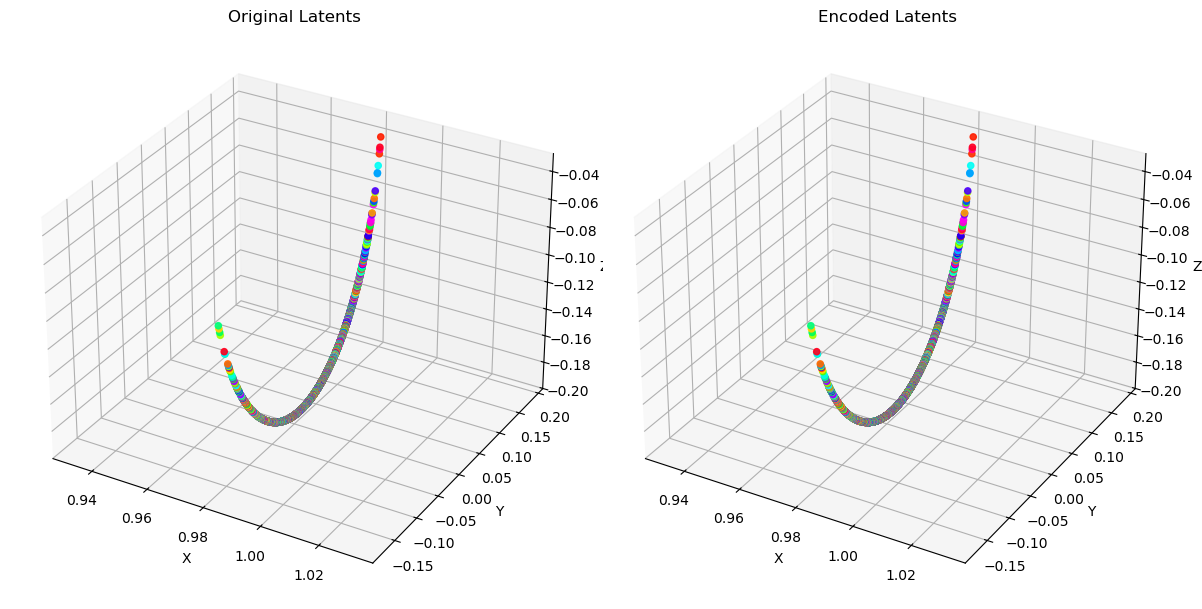

In [15]:
z = sample_uniform_fixed(1).squeeze(0)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch_size) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(batch_size, 1), aug_samples_v), dim=-1)

visualize_spheres_side_by_side(plt, z_aug, z_aug)

## Training the identity generating process

$g(z) = z$

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.317998886108398 Samples processed: 1 linear disentanglement: 0.5557892322540283 permutation disentanglement: 6.888309872010723e-05
Loss: 8.198200225830078 Samples processed: 251 linear disentanglement: 0.42075052857398987 permutation disentanglement: 0.2739894390106201
Loss: 8.195913314819336 Samples processed: 501 linear disentanglement: 0.30825793743133545 permutation disentanglement: 0.2687283158302307
Loss: 8.195740699768066 Samples processed: 751 linear disentanglement: 0.3015117049217224 permutation disentanglement: 0.24446189403533936
Loss: 8.19576644897461 Samples processed: 1001 linear disentanglement: 0.30164459347724915 permutation disentanglement: 0.24439121782779694
Loss: 8.195751190185547 Samples processed: 1251 linear disentanglement: 0.3007582724094391 permutation disentanglement: 0.24276326596736908
Loss: 8.195738792419434 Samples processed: 1501 linear disentanglement: 0.3001881241798401 permutation dise

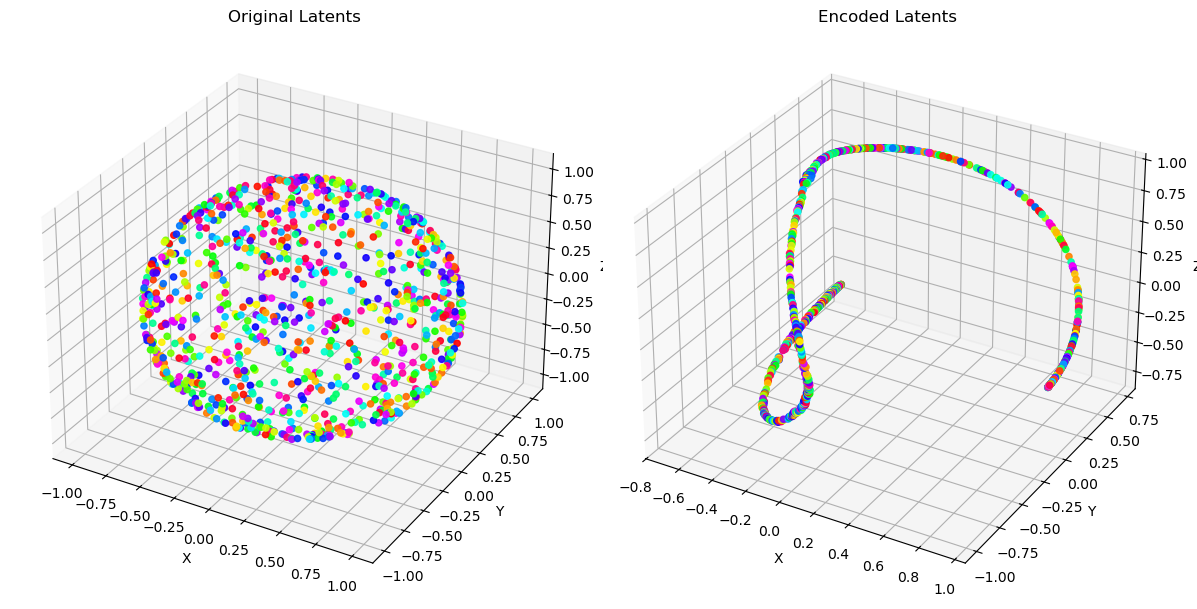

In [18]:
# Initialize the multi-layer perceptron used for encoding
f_constrained = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

g_id = nn.Identity()

h_constrained = lambda z: f_constrained(g_id(z))

simclr_vmf = SimCLR(
    f_constrained, g_id, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_constrained = simclr_vmf.train(batch_size, iterations)

z = full_sphere.uniform(1000).to(device)
z_enc = h_constrained(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

## Linear map generating process

$g(z) = Az$, where $A \in \mathbb{R}^{k \times 3}$ and $k \in \{4,5,6,7\}$ and $rank(A) = 3$

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.318002700805664 Samples processed: 1 linear disentanglement: 0.5102500319480896 permutation disentanglement: 5.2928924560546875e-05
Loss: 8.215909004211426 Samples processed: 251 linear disentanglement: 0.4956153929233551 permutation disentanglement: 0.2520770728588104
Loss: 8.204535484313965 Samples processed: 501 linear disentanglement: 0.6280698180198669 permutation disentanglement: 0.1832399219274521
Loss: 8.204436302185059 Samples processed: 751 linear disentanglement: 0.6326839327812195 permutation disentanglement: 0.20987044274806976
Loss: 8.203811645507812 Samples processed: 1001 linear disentanglement: 0.6446326971054077 permutation disentanglement: 0.3070118725299835
Loss: 8.201640129089355 Samples processed: 1251 linear disentanglement: 0.6423588395118713 permutation disentanglement: 0.29087215662002563
Loss: 8.20223617553711 Samples processed: 1501 linear disentanglement: 0.6236128807067871 permutation disenta

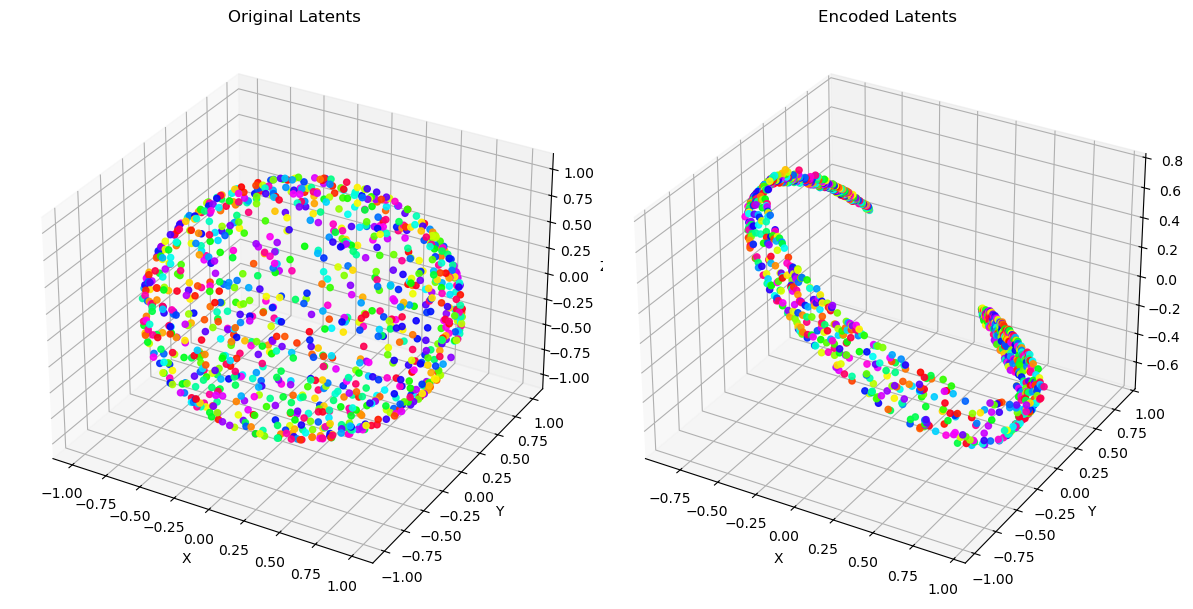

In [19]:
from experiment_utils.linear import perform_linear_experiment

h = perform_linear_experiment(
    4, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.317995071411133 Samples processed: 1 linear disentanglement: 0.37873128056526184 permutation disentanglement: 0.0007217526435852051
Loss: 8.197023391723633 Samples processed: 251 linear disentanglement: 0.3397117555141449 permutation disentanglement: 0.19225043058395386
Loss: 8.196491241455078 Samples processed: 501 linear disentanglement: 0.30705752968788147 permutation disentanglement: 0.12343200296163559
Loss: 8.19576644897461 Samples processed: 751 linear disentanglement: 0.2894068658351898 permutation disentanglement: 0.03261168673634529
Loss: 8.195699691772461 Samples processed: 1001 linear disentanglement: 0.28741565346717834 permutation disentanglement: 0.03290535882115364
Loss: 8.195711135864258 Samples processed: 1251 linear disentanglement: 0.2888265550136566 permutation disentanglement: 0.03901034593582153
Loss: 8.195741653442383 Samples processed: 1501 linear disentanglement: 0.2873775064945221 permutation di

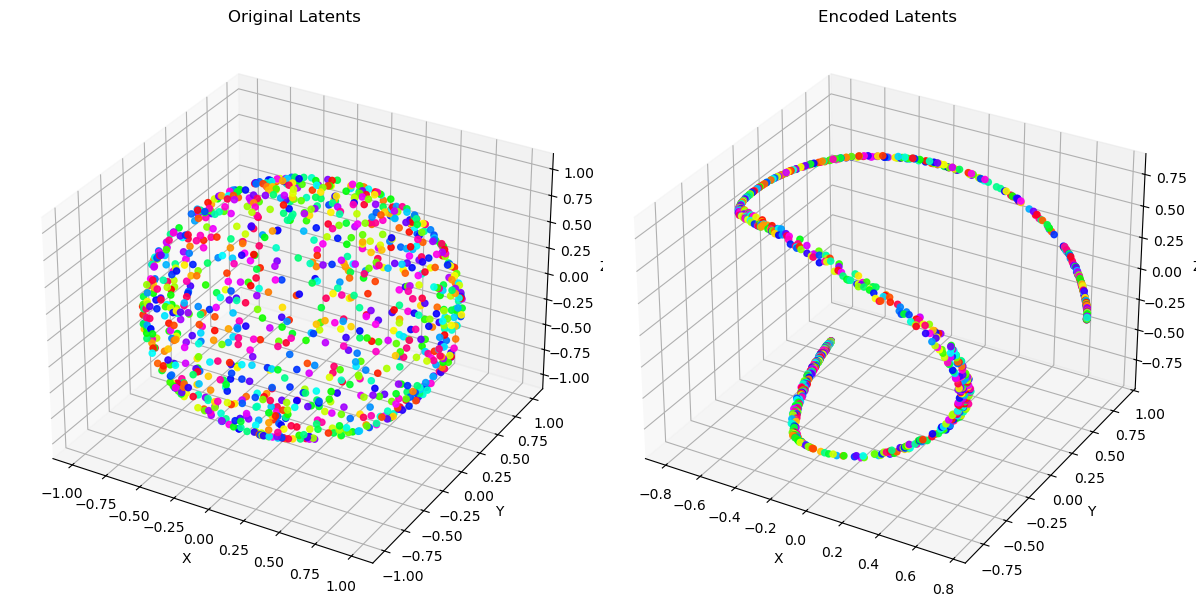

In [20]:
from experiment_utils.linear import perform_linear_experiment

h = perform_linear_experiment(
    5, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.317915916442871 Samples processed: 1 linear disentanglement: 0.5978405475616455 permutation disentanglement: 0.0007389386300928891
Loss: 8.197320938110352 Samples processed: 251 linear disentanglement: 0.5733940005302429 permutation disentanglement: 0.269060879945755
Loss: 8.195747375488281 Samples processed: 501 linear disentanglement: 0.29725274443626404 permutation disentanglement: 0.16906338930130005
Loss: 8.195719718933105 Samples processed: 751 linear disentanglement: 0.29837507009506226 permutation disentanglement: 0.16147495806217194
Loss: 8.195762634277344 Samples processed: 1001 linear disentanglement: 0.2996957004070282 permutation disentanglement: 0.15920360386371613
Loss: 8.195785522460938 Samples processed: 1251 linear disentanglement: 0.2984699308872223 permutation disentanglement: 0.15940149128437042
Loss: 8.19571304321289 Samples processed: 1501 linear disentanglement: 0.29888254404067993 permutation dise

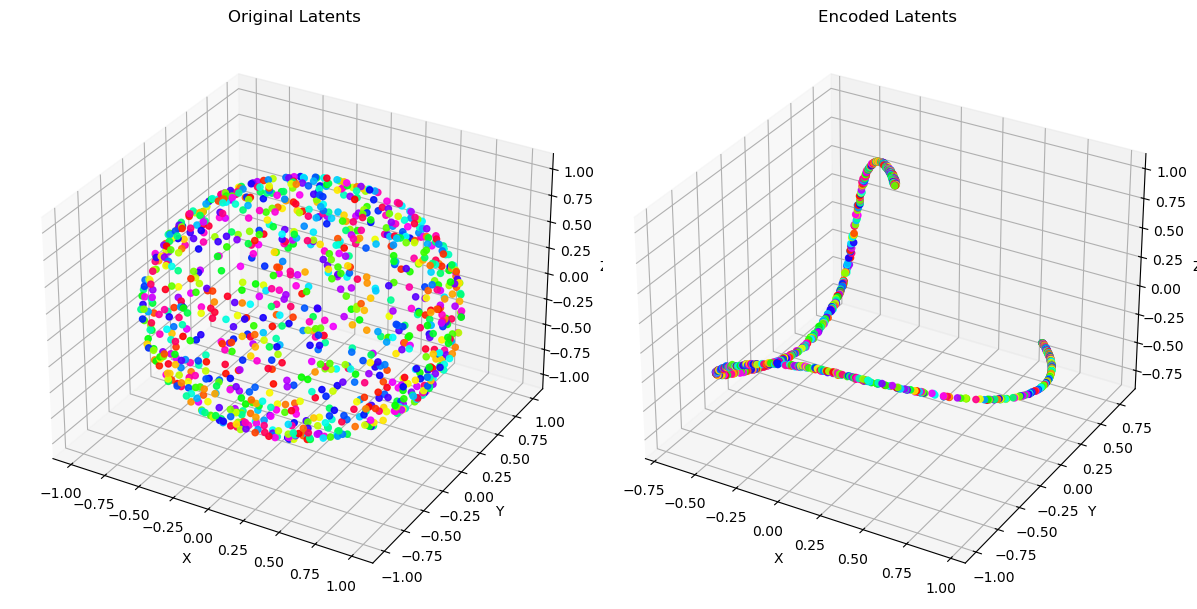

In [21]:
from experiment_utils.linear import perform_linear_experiment

h = perform_linear_experiment(
    6, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.317718505859375 Samples processed: 1 linear disentanglement: 0.557361364364624 permutation disentanglement: 0.0015105208149179816
Loss: 8.196966171264648 Samples processed: 251 linear disentanglement: 0.3822556436061859 permutation disentanglement: 0.12030152231454849
Loss: 8.195846557617188 Samples processed: 501 linear disentanglement: 0.2997552454471588 permutation disentanglement: 0.0037392775993794203
Loss: 8.195690155029297 Samples processed: 751 linear disentanglement: 0.2996731102466583 permutation disentanglement: 0.0041314163245260715
Loss: 8.195816993713379 Samples processed: 1001 linear disentanglement: 0.29842737317085266 permutation disentanglement: 0.0035899083595722914
Loss: 8.195691108703613 Samples processed: 1251 linear disentanglement: 0.29877176880836487 permutation disentanglement: 0.0035660862922668457
Loss: 8.195810317993164 Samples processed: 1501 linear disentanglement: 0.2978907823562622 permuta

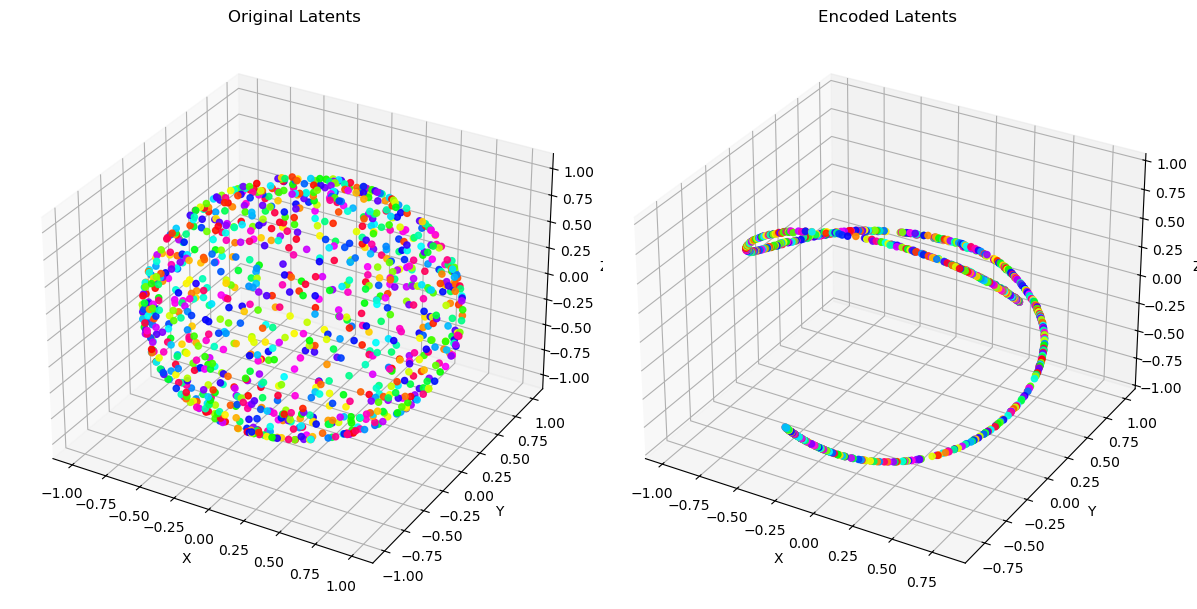

In [22]:
from experiment_utils.linear import perform_linear_experiment

h = perform_linear_experiment(
    7, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())